# Predictive Maintenance using the Condition monitoring of hydraulic systems Data Set

In this notebook, we will use the dateset (https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems) to demonstrate the training of machine learning models to predict faults.

Creator of the dataset: ZeMA gGmbH, Eschberger Weg 46, 66121 Saarbrücken

For more information, refer to: Nikolai Helwig, Eliseo Pignanelli, Andreas Schätze, Condition Monitoring of a Complex Hydraulic System Using Multivariate Statistics, in Proc. I2MTC-2015 - 2015 IEEE International Instrumentation and Measurement Technology Conference, paper PPS1-39, Pisa, Italy, May 11-14, 2015, doi: 10.1109/I2MTC.2015.7151267.

Data Set Information:
The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a primary working and a secondary cooling-filtration circuit which are connected via the oil tank. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump and accumulator) is quantitatively varied.

Attribute Information:
The data set contains raw process sensor data (i.e. without feature extraction) which are structured as matrices (tab-delimited) with the rows representing the cycles and the columns the data points within a cycle. The sensors involved are:
Sensor Physical quantity Unit Sampling rate
PS1 Pressure bar 100 Hz
PS2 Pressure bar 100 Hz
PS3 Pressure bar 100 Hz
PS4 Pressure bar 100 Hz
PS5 Pressure bar 100 Hz
PS6 Pressure bar 100 Hz
EPS1 Motor power W 100 Hz
FS1 Volume flow l/min 10 Hz
FS2 Volume flow l/min 10 Hz
TS1 Temperature Â°C 1 Hz
TS2 Temperature Â°C 1 Hz
TS3 Temperature Â°C 1 Hz
TS4 Temperature Â°C 1 Hz
VS1 Vibration mm/s 1 Hz
CE Cooling efficiency (virtual) % 1 Hz
CP Cooling power (virtual) kW 1 Hz
SE Efficiency factor % 1 Hz

The target condition values are cycle-wise annotated in profile.txt (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %:
3: close to total failure
20: reduced effifiency
100: full efficiency

2: Valve condition / %:
100: optimal switching behavior
90: small lag
80: severe lag
73: close to total failure

3: Internal pump leakage:
0: no leakage
1: weak leakage
2: severe leakage

4: Hydraulic accumulator / bar:
130: optimal pressure
115: slightly reduced pressure
100: severely reduced pressure
90: close to total failure

5: stable flag:
0: conditions were stable
1: static conditions might not have been reached yet

## Goal

Our goal is to find a model that is able to predict the correct condition of flag (0,1) based on a feature matrix describing the condition of the complete hydraulic system.

Since we have labels (flags) for 2205 measurement cycles, we need a feature matrix of the shape (2205 x F), where F is the number of different features which have to be extracted from the given measurement datasets for each measurement cycle.

We will use the measurements of two different temperature sensors. Four each of the 2205 measurement cycles, we have 2 time series representing the measurements of the different temperature sensors. Each of the time series consists of 60 measurements. This means, we have to extract features describing the different time series.

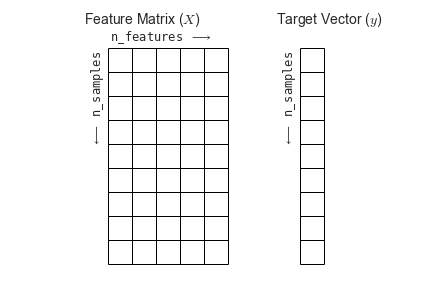

In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
### LOAD DATA ###

label = pd.read_csv('profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']

#data = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']
data = ['TS1.txt','TS2.txt']
df = pd.DataFrame()

for txt in data:
    read_df = pd.read_csv(txt, sep='\t', header=None)
    df = df.append(read_df)    

print(df.shape)
df.head()

(4410, 60)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,...,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,...,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,...,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
3,38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,...,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
4,39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,...,40.324,40.320,40.312,40.340,40.320,40.387,40.391,40.391,40.387,40.391


In [3]:
n=int(len(df)/len(data))
m=len(df.columns)
print(n,'measurement cycles')
print(m,'measurements per cycle')
print(len(data),'temperature sensors')

2205 measurement cycles
60 measurements per cycle
2 temperature sensors


In [4]:
df.isnull().sum().sum()

0

In [5]:
df.duplicated().sum()

0

In [6]:
df1 = df.sort_index()
df1

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,...,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
0,40.961,40.949,40.965,40.922,40.879,40.879,40.828,40.812,40.809,40.785,...,41.211,41.129,41.195,41.211,41.207,41.191,41.207,41.207,41.129,41.250
1,41.258,41.277,41.262,41.223,41.211,41.176,41.129,41.129,41.070,41.031,...,41.949,41.941,41.980,41.957,41.980,42.020,42.023,42.031,42.078,42.105
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,...,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,...,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,35.434,35.355,35.262,35.187,35.266,35.102,35.105,35.094,35.016,35.016,...,35.500,35.434,35.410,35.434,35.426,35.437,35.441,35.410,35.434,35.437
2203,40.906,40.906,40.891,40.895,40.855,40.816,40.812,40.828,40.812,40.812,...,40.934,40.961,40.957,40.926,40.898,40.934,40.910,40.926,40.918,40.898
2203,35.449,35.359,35.277,35.184,35.195,35.184,35.105,35.016,35.012,35.008,...,35.437,35.531,35.426,35.516,35.422,35.441,35.461,35.414,35.426,35.441
2204,35.422,35.336,35.250,35.176,35.195,35.094,35.102,35.094,35.012,35.012,...,35.437,35.453,35.520,35.437,35.437,35.441,35.437,35.434,35.434,35.426


For plotting, we need the data in the following format: (number of measurement cycles x number of measurements per cycle x number of sensors) = (2205 x 60 x 4)

In [7]:
df1 = df.sort_index().values.reshape(-1,len(data),len(df.columns))
df1.shape

(2205, 2, 60)

In [8]:
### RESHAPE DATA AMONG SENSORS ###

df = df.sort_index().values.reshape(-1,len(data),len(df.columns)).transpose(0,2,1)
df.shape

(2205, 60, 2)

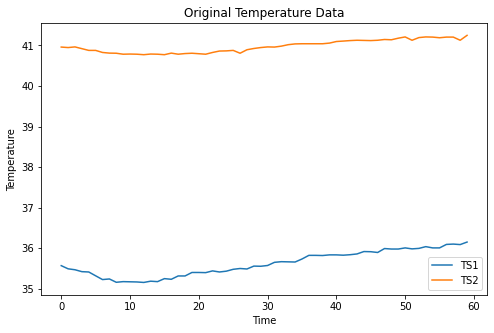

In [9]:
### PLOT ORIGINAL TEMPERATURE DATA ###
# Measurements of the 4 sensors of the first measurement cycle

plt.figure(figsize=(8,5))
plt.plot(df[0])
plt.title('Original Temperature Data')
plt.ylabel('Temperature'); plt.xlabel('Time')
#plt.legend(['TS1','TS2','TS3','TS4'])
plt.legend(['TS1','TS2'])
np.set_printoptions(False)

In [10]:
label

,Cooler,Valve,Pump,Accumulator,Flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1
...,...,...,...,...,...
2200,100,100,0,90,0
2201,100,100,0,90,0
2202,100,100,0,90,0
2203,100,100,0,90,0


In [11]:
### LABEL DISTRIBUTION ### We only want to consider the variable FLAG
# Flag:
# 0: conditions were stable 
# 1: unstable conditions

label = label.Flag
label.value_counts()

0    1449
1     756
Name: Flag, dtype: int64

In [12]:
label

0       1
1       1
2       1
3       1
4       1
       ..
2200    0
2201    0
2202    0
2203    0
2204    0
Name: Flag, Length: 2205, dtype: int64

In [13]:
label.unique()

array([1, 0], dtype=int64)

In [14]:
for i,j in enumerate(label.unique()):
    print(i,j)

0 1
1 0


In [15]:
### MAPPING LABEL ###

diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = label.astype("category")

{1: 0, 0: 1}
{0: 1, 1: 0}


In [16]:
label

0       0
1       0
2       0
3       0
4       0
       ..
2200    1
2201    1
2202    1
2203    1
2204    1
Name: Flag, Length: 2205, dtype: int64

## Extract Features with the tsfresh package

For applying the tsfresh package, we need two columns specifying the ids (measurement cycle number) and the times (time points of each measurement cycle).

In [17]:
#df2=pd.DataFrame(df.reshape(-1,4))
df2=pd.DataFrame(df.reshape(-1,2))
df2

,0,1
0,35.570,40.961
1,35.492,40.949
2,35.469,40.965
3,35.422,40.922
4,35.414,40.879
...,...,...
132295,35.441,40.910
132296,35.437,40.895
132297,35.434,40.883
132298,35.434,40.879


In [18]:
tmp=pd.DataFrame()
for i in range(n):
    tmp=tmp.append(pd.DataFrame(np.arange(m)))
tmp[55:65]

,0
55,55
56,56
57,57
58,58
59,59
0,0
1,1
2,2
3,3
4,4


In [19]:
df2['time']=tmp.values
df2

,0,1,time
0,35.570,40.961,0
1,35.492,40.949,1
2,35.469,40.965,2
3,35.422,40.922,3
4,35.414,40.879,4
...,...,...,...
132295,35.441,40.910,55
132296,35.437,40.895,56
132297,35.434,40.883,57
132298,35.434,40.879,58


In [20]:
df2['id']=np.repeat(range(n),m)
df2

,0,1,time,id
0,35.570,40.961,0,0
1,35.492,40.949,1,0
2,35.469,40.965,2,0
3,35.422,40.922,3,0
4,35.414,40.879,4,0
...,...,...,...,...
132295,35.441,40.910,55,2204
132296,35.437,40.895,56,2204
132297,35.434,40.883,57,2204
132298,35.434,40.879,58,2204


In [21]:
df2.head(66)

,0,1,time,id
0,35.570,40.961,0,0
1,35.492,40.949,1,0
2,35.469,40.965,2,0
3,35.422,40.922,3,0
4,35.414,40.879,4,0
...,...,...,...,...
61,41.277,36.094,1,1
62,41.262,35.992,2,1
63,41.223,36.008,3,1
64,41.211,35.992,4,1


In [22]:
from tsfresh import extract_features
extracted_features = extract_features(df2, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████████████████| 20/20 [03:13<00:00,  9.69s/it]


In [24]:
extracted_features.shape

(2205, 1578)

In [25]:
extracted_features.iloc[:,1:10]

,1__has_duplicate_max,1__has_duplicate_min,1__has_duplicate,1__sum_values,1__abs_energy,1__mean_abs_change,1__mean_change,1__mean_second_derivative_central,1__median
0,0.0,1.0,1.0,2458.726,100756.963784,0.023339,0.004898,0.001147,40.9630
1,0.0,0.0,1.0,2200.618,80732.235434,0.044356,0.022390,0.000440,36.7675
2,0.0,0.0,1.0,2546.547,108090.694711,0.031763,0.015356,0.000172,42.4235
3,0.0,0.0,1.0,2604.239,113043.714345,0.026153,0.016085,0.000198,43.3650
4,0.0,0.0,1.0,2659.965,117931.761797,0.030000,0.014237,-0.000103,44.3355
...,...,...,...,...,...,...,...,...,...
2200,0.0,0.0,1.0,2118.827,74824.985475,0.030305,0.000000,0.000569,35.4100
2201,0.0,0.0,1.0,2119.296,74858.045014,0.033186,-0.000610,0.000845,35.3765
2202,0.0,0.0,1.0,2119.151,74848.046529,0.040119,0.000051,0.000707,35.4060
2203,0.0,1.0,1.0,2119.486,74871.835654,0.046881,-0.000136,0.000905,35.4120


In [26]:
extracted_features.columns

Index(['1__variance_larger_than_standard_deviation', '1__has_duplicate_max',
       '1__has_duplicate_min', '1__has_duplicate', '1__sum_values',
       '1__abs_energy', '1__mean_abs_change', '1__mean_change',
       '1__mean_second_derivative_central', '1__median',
       ...
       '0__permutation_entropy__dimension_6__tau_1',
       '0__permutation_entropy__dimension_7__tau_1',
       '0__query_similarity_count__query_None__threshold_0.0',
       '0__matrix_profile__feature_"min"__threshold_0.98',
       '0__matrix_profile__feature_"max"__threshold_0.98',
       '0__matrix_profile__feature_"mean"__threshold_0.98',
       '0__matrix_profile__feature_"median"__threshold_0.98',
       '0__matrix_profile__feature_"25"__threshold_0.98',
       '0__matrix_profile__feature_"75"__threshold_0.98',
       '0__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=1578)

In [27]:
extracted_features.shape

(2205, 1578)

In [28]:
pd.isna(extracted_features).sum().sum()

1256543

In [29]:
#drop NaN-values
extracted_features=extracted_features.dropna(axis='columns')

In [30]:
pd.isna(extracted_features).sum().sum()

0

In [31]:
extracted_features.shape

(2205, 998)

In [32]:
# find infinite values and set them to NaN
extracted_features.replace([np.inf, -np.inf], np.nan, inplace=True)

In [33]:
pd.isna(extracted_features).sum().sum()

0

In [34]:
# drop NaN values
extracted_features=extracted_features.dropna(axis='columns')

In [35]:
pd.isna(extracted_features).sum().sum()

0

In [36]:
extracted_features.shape

(2205, 998)

In [37]:
extracted_features.columns

Index(['1__variance_larger_than_standard_deviation', '1__has_duplicate_max',
       '1__has_duplicate_min', '1__has_duplicate', '1__sum_values',
       '1__abs_energy', '1__mean_abs_change', '1__mean_change',
       '1__mean_second_derivative_central', '1__median',
       ...
       '0__fourier_entropy__bins_3', '0__fourier_entropy__bins_5',
       '0__fourier_entropy__bins_10', '0__fourier_entropy__bins_100',
       '0__permutation_entropy__dimension_3__tau_1',
       '0__permutation_entropy__dimension_4__tau_1',
       '0__permutation_entropy__dimension_5__tau_1',
       '0__permutation_entropy__dimension_6__tau_1',
       '0__permutation_entropy__dimension_7__tau_1',
       '0__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=998)

## Feature Selection 

In [38]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, label)

In [39]:
features_filtered.shape

(2205, 186)

## Train-Test-Split 

In [40]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, random_state = 1, test_size=0.2)

In [46]:
X_train_filt, X_test_filt, y_train, y_test = train_test_split(features_filtered, y, random_state = 1, test_size=0.2)

In [47]:
X_train.sort_index().index

Int64Index([   0,    1,    2,    4,    5,    7,    9,   10,   11,   12,
            ...
            2194, 2195, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204],
           dtype='int64', length=1764)

In [48]:
X_train_filt.sort_index().index

Int64Index([   0,    1,    2,    4,    5,    7,    9,   10,   11,   12,
            ...
            2194, 2195, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204],
           dtype='int64', length=1764)

In [49]:
Train_ids=X_train.sort_index().index

In [50]:
Test_ids=X_test.sort_index().index

In [51]:
y_train.shape

(1764,)

In [52]:
X_train.shape

(1764, 998)

In [53]:
X_train_filt.shape

(1764, 186)

In [54]:
y_test.shape

(441,)

In [55]:
X_test.shape

(441, 998)

In [56]:
X_test_filt.shape

(441, 186)

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

    z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [58]:
### SCALE DATA ###

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_filt_std = scaler.fit_transform(X_train_filt)
X_test_filt_std = scaler.transform(X_test_filt)

# MODEL

### Decision Tree

In [59]:
# Train Decision Tree with original feature matrix
from sklearn import tree
clf_dt1 = tree.DecisionTreeClassifier(random_state=1)
clf_dt1 = clf_dt1.fit(X_train,y_train)
y_pred_clf_dt1 = clf_dt1.predict(X_test)

In [60]:
# Train Decision Tree with standardized feature matrix
clf_dt2 = tree.DecisionTreeClassifier(random_state=1)
clf_dt2 = clf_dt2.fit(X_train_std,y_train)
y_pred_clf_dt2 = clf_dt2.predict(X_test_std)

In [61]:
# Train Decision Tree with standardized and filtered feature matrix
clf_dt3 = tree.DecisionTreeClassifier(random_state=1)
clf_dt3 = clf_dt3.fit(X_train_filt_std,y_train)
y_pred_clf_dt3 = clf_dt3.predict(X_test_filt_std)

Decision Tree clf_dt1 without standardization of feature columns
accuracy= 0.8594104308390023


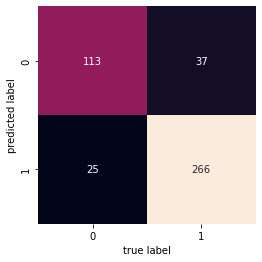

In [62]:
print('Decision Tree clf_dt1 without standardization of feature columns')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_dt1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_dt1))

Decision Tree clf_dt2 with standardization of feature columns
accuracy= 0.8843537414965986


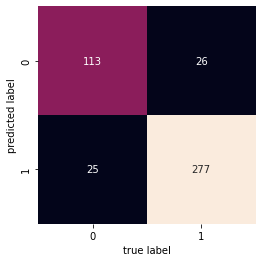

In [63]:
print('Decision Tree clf_dt2 with standardization of feature columns')
#
mat = confusion_matrix(y_test, y_pred_clf_dt2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_clf_dt2))

Decision Tree clf_dt3 with standardization of feature columns after feature selection
accuracy= 0.7414965986394558


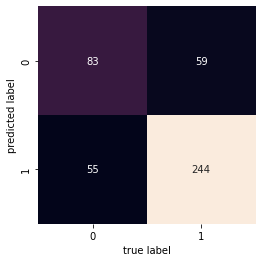

In [64]:
print('Decision Tree clf_dt3 with standardization of feature columns after feature selection')
#
mat = confusion_matrix(y_test, y_pred_clf_dt3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_clf_dt3))

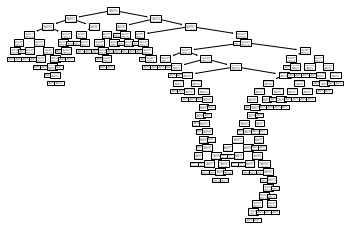

In [66]:
tree.plot_tree(clf_dt1)
plt.show()

## Naive Bayes 

In [67]:
# Train Naive Bayes Classifier with original feature matrix
from sklearn.naive_bayes import GaussianNB
clf_gnb1 = GaussianNB()
clf_gnb1 = clf_gnb1.fit(X_train,y_train)
y_pred_clf_gnb1 = clf_gnb1.predict(X_test)

In [68]:
# Train Naive Bayes Classifier with standardized feature matrix
clf_gnb2 = GaussianNB()
clf_gnb2 = clf_gnb2.fit(X_train_std,y_train)
y_pred_clf_gnb2 = clf_gnb2.predict(X_test_std)

In [69]:
# Train Naive Bayes Classifier with standardized and filtered feature matrix
from sklearn.naive_bayes import GaussianNB
clf_gnb3 = GaussianNB()
clf_gnb3 = clf_gnb3.fit(X_train_filt_std,y_train)
y_pred_clf_gnb3 = clf_gnb3.predict(X_test_filt_std)

Naive Bayes Classifier clf_gnb1 without standardization of feature columns
accuracy= 0.5578231292517006


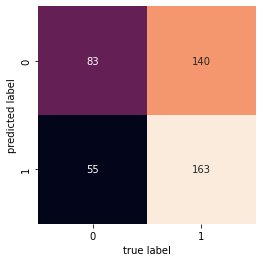

In [70]:
print('Naive Bayes Classifier clf_gnb1 without standardization of feature columns')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_gnb1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_gnb1))

Naive Bayes Classifier clf_gnb2 with standardization of feature columns
accuracy= 0.564625850340136


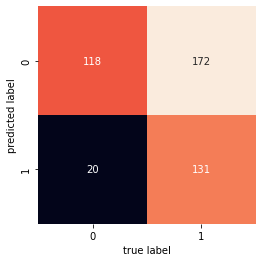

In [71]:
print('Naive Bayes Classifier clf_gnb2 with standardization of feature columns')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_gnb2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_gnb2))

Naive Bayes Classifier clf_gnb3 with standardization of feature columns after feature selection
accuracy= 0.5691609977324263


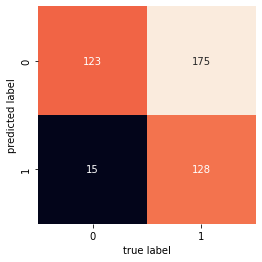

In [72]:
print('Naive Bayes Classifier clf_gnb3 with standardization of feature columns after feature selection')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_gnb3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_gnb3))

## Support Vector Machine 

In [73]:
# Train Support Vector Machine with original feature matrix
from sklearn import svm
clf_svm1 = svm.SVC()
clf_svm1 = clf_svm1.fit(X_train,y_train)
y_pred_clf_svm1 = clf_svm1.predict(X_test)

In [74]:
# Train Support Vector Machine with standardized feature matrix
from sklearn import svm
clf_svm2 = svm.SVC()
clf_svm2 = clf_svm2.fit(X_train_std,y_train)
y_pred_clf_svm2 = clf_svm2.predict(X_test_std)

In [75]:
# Train Support Vector Machine with standardized and filtered feature matrix
from sklearn import svm
clf_svm3 = svm.SVC()
clf_svm3 = clf_svm3.fit(X_train_filt_std,y_train)
y_pred_clf_svm3 = clf_svm3.predict(X_test_filt_std)

Support Vector Machine clf_svm1 without standardization of feature columns
accuracy= 0.6870748299319728


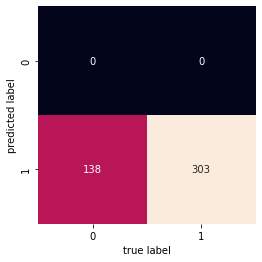

In [76]:
print('Support Vector Machine clf_svm1 without standardization of feature columns')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_svm1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_svm1))

Support Vector Machine clf_svm2 with standardization of feature columns
accuracy= 0.81859410430839


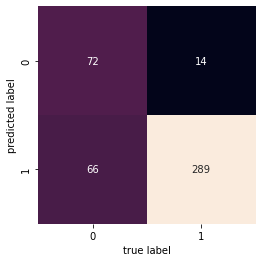

In [77]:
print('Support Vector Machine clf_svm2 with standardization of feature columns')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_svm2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_svm2))

Support Vector Machine clf_svm3 with standardization of feature columns after feature selection
accuracy= 0.7981859410430839


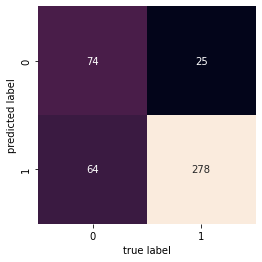

In [78]:
print('Support Vector Machine clf_svm3 with standardization of feature columns after feature selection')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_svm3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_svm3))

## k-Nearest Neighbors Classifier 

In [79]:
# Train knn Classifier with original feature matrix
from sklearn.neighbors import KNeighborsClassifier
clf_knn1 = KNeighborsClassifier(n_neighbors=5)
clf_knn1 = clf_knn1.fit(X_train,y_train)
y_pred_clf_knn1 = clf_knn1.predict(X_test)

In [80]:
# Train knn Classifier with standardized feature matrix
from sklearn.neighbors import KNeighborsClassifier
clf_knn2 = KNeighborsClassifier(n_neighbors=5)
clf_knn2 = clf_knn2.fit(X_train_std,y_train)
y_pred_clf_knn2 = clf_knn2.predict(X_test_std)

In [81]:
# Train knn Classifier with standardized and filtered feature matrix
from sklearn.neighbors import KNeighborsClassifier
clf_knn3 = KNeighborsClassifier(n_neighbors=5)
clf_knn3 = clf_knn3.fit(X_train_filt_std,y_train)
y_pred_clf_knn3 = clf_knn3.predict(X_test_filt_std)

k-Nearest Neighbor Classifier clf_knn1 without standardization of feature columns
accuracy= 0.9410430839002267


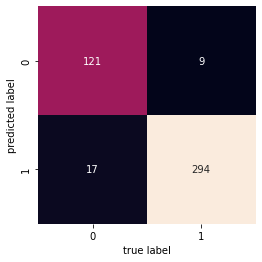

In [82]:
print('k-Nearest Neighbor Classifier clf_knn1 without standardization of feature columns')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_knn1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_knn1))

k-Nearest Neighbor Classifier clf_knn2 with standardization of feature columns
accuracy= 0.8072562358276644


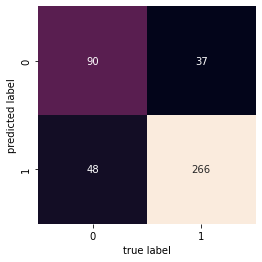

In [83]:
print('k-Nearest Neighbor Classifier clf_knn2 with standardization of feature columns')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_knn2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_knn2))

k-Nearest Neighbor Classifier clf_knn3 with standardization of feature columns after feature selection
accuracy= 0.8208616780045351


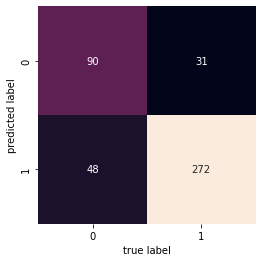

In [84]:
print('k-Nearest Neighbor Classifier clf_knn3 with standardization of feature columns after feature selection')
#
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_clf_knn3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
from sklearn.metrics import accuracy_score
print('accuracy=',accuracy_score(y_test, y_pred_clf_knn3))

### Random Forest 

In [85]:
# Train Random Forest with original feature matrix
from sklearn.ensemble import RandomForestClassifier
clf_rf1 = RandomForestClassifier(n_estimators=50,random_state=1)
clf_rf1 = clf_rf1.fit(X_train,y_train)
y_pred_rf1 = clf_rf1.predict(X_test)

In [86]:
# Train Random Forest with standardized feature matrix
clf_rf2 = RandomForestClassifier(n_estimators=50,random_state=1)
clf_rf2 = clf_rf2.fit(X_train_std,y_train)
y_pred_rf2 = clf_rf2.predict(X_test_std)

In [87]:
# Train Random Forest with standardized and filtered feature matrix
clf_rf3 = RandomForestClassifier(n_estimators=50,random_state=1)
clf_rf3 = clf_rf3.fit(X_train_filt_std,y_train)
y_pred_rf3 = clf_rf3.predict(X_test_filt_std)

Random Forest clf_rf1 without standardization of feature columns
accuracy= 0.9455782312925171


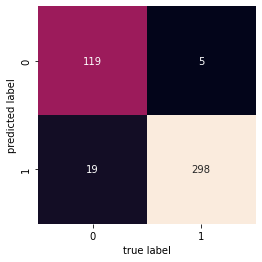

In [88]:
print('Random Forest clf_rf1 without standardization of feature columns')
#
mat = confusion_matrix(y_test, y_pred_rf1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_rf1))

Random Forest clf_rf2 with standardization of feature columns
accuracy= 0.9365079365079365


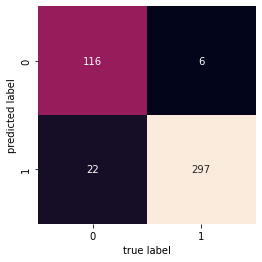

In [89]:
print('Random Forest clf_rf2 with standardization of feature columns')
#
mat = confusion_matrix(y_test, y_pred_rf2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_rf2))

Random Forest clf_rf3 with standardization of feature columns after feature selection
accuracy= 0.8321995464852607


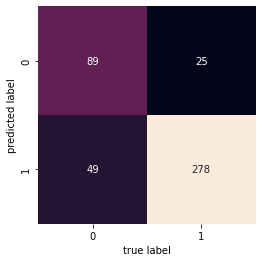

In [90]:
print('Random Forest clf_rf3 with standardization of feature columns after feature selection')
#
mat = confusion_matrix(y_test, y_pred_rf3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_rf3))

## Neural Network (Multilayer Perceptron)

In [91]:
# Train Neural Network with original feature matrix
from sklearn.neural_network import MLPClassifier
clf_mlp1 = MLPClassifier(random_state=1)
clf_mlp1 = clf_mlp1.fit(X_train,y_train)
y_pred_mlp1 = clf_mlp1.predict(X_test)

In [92]:
# Train Neural Network with standardized feature matrix
clf_mlp2 = MLPClassifier(random_state=1)
clf_mlp2 = clf_mlp2.fit(X_train_std,y_train)
y_pred_mlp2 = clf_mlp2.predict(X_test_std)

In [93]:
# Train Neural Network with standardized and filtered feature matrix
clf_mlp3 = MLPClassifier(random_state=1)
clf_mlp3 = clf_mlp3.fit(X_train_filt_std,y_train)
y_pred_mlp3 = clf_mlp3.predict(X_test_filt_std)

C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Multilayer Perceptron clf_mlp1 without standardization of feature columns
accuracy= 0.6870748299319728


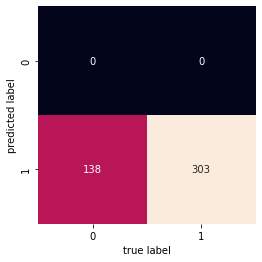

In [94]:
print('Multilayer Perceptron clf_mlp1 without standardization of feature columns')
#
mat = confusion_matrix(y_test, y_pred_mlp1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_mlp1))

Multilayer Perceptron clf_mlp2 with standardization of feature columns
accuracy= 0.8163265306122449


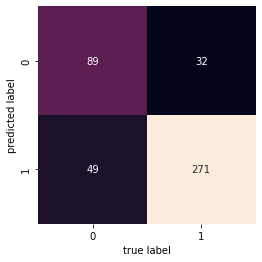

In [95]:
print('Multilayer Perceptron clf_mlp2 with standardization of feature columns')
#
mat = confusion_matrix(y_test, y_pred_mlp2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_mlp2))

Multilayer Perceptron clf_mlp3 with standardization of feature columns after feature selection
accuracy= 0.8117913832199547


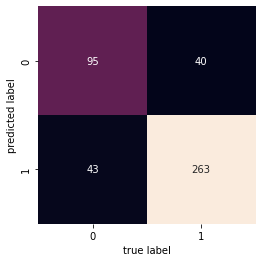

In [96]:
print('Multilayer Perceptron clf_mlp3 with standardization of feature columns after feature selection')
#
mat = confusion_matrix(y_test, y_pred_mlp3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_mlp3))

## Ensemble of Neural Networks 

In [97]:
from sklearn.ensemble import BaggingClassifier
clf_bag = BaggingClassifier(base_estimator=MLPClassifier(),
                            n_estimators=10, random_state=1
                           ).fit(X_train_filt_std, y_train)
y_pred_bag = clf_bag.predict(X_test_filt_std)

C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Bagged Ensemble of MLPs clf_bag with standardization of feature columns
accuracy= 0.8253968253968254


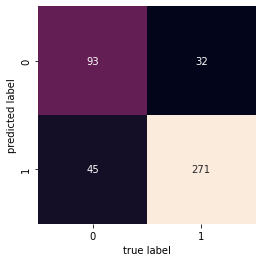

In [98]:
print('Bagged Ensemble of MLPs clf_bag with standardization of feature columns')
#
mat = confusion_matrix(y_test, y_pred_bag)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_bag))

## Ensembles (Voting Classifier) 

In [99]:
# Ensemble Voting Classifier with majority voting
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(
    estimators=[('dt', clf_dt3), ('svm', clf_svm3), ('mlp', clf_mlp3),
               ('knn', clf_knn3)],
    voting='hard')
eclf1 = eclf1.fit(X_train_filt_std,y_train)

C:\Users\Mirko\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [100]:
y_pred_eclf1 = eclf1.predict(X_test_filt_std)

Voting Classifier eclf1 with majority voting
accuracy= 0.8412698412698413


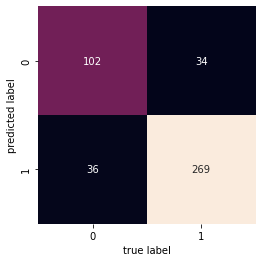

In [101]:
print('Voting Classifier eclf1 with majority voting')
#
mat = confusion_matrix(y_test, y_pred_eclf1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
#
print('accuracy=',accuracy_score(y_test, y_pred_eclf1))

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_eclf1))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       138
           1       0.88      0.89      0.88       303

    accuracy                           0.84       441
   macro avg       0.82      0.81      0.81       441
weighted avg       0.84      0.84      0.84       441

